## importing required libraries

In [1]:
import pandas as pd
import numpy as np

#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
#nltk.download('punkt')
#nltk.download('averaged_perceptron_tagger')
#nltk.download('wordnet')
#nltk.download("stopwords")

#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score

# bag of words and TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

#for word embedding
!pip install gensim
import gensim
from gensim.models import Word2Vec

#for visualisation
import seaborn as sns
import matplotlib.pyplot as plt


# Loading Dataset

In [2]:
# The raw data is collected through web scrapping Subreddits. 
# The data is only in English language.
# It mainly targets mental health classification.

In [3]:
df = pd.read_csv(r"C:\Users\pritam\Downloads\depression_dataset_reddit_cleaned.csv\depression_dataset_reddit_cleaned.csv")

In [4]:
df.columns = ['text', 'depression']

In [5]:
df.head()

,text,depression
0,we understand that most people who reply immed...,1
1,welcome to r depression s check in post a plac...,1
2,anyone else instead of sleeping more when depr...,1
3,i ve kind of stuffed around a lot in my life d...,1
4,sleep is my greatest and most comforting escap...,1


In [6]:
# no na value in our dataset

df.isna().sum()

text          0
depression    0
dtype: int64

In [7]:
df.shape

(7731, 2)

## EDA

0    3900
1    3831
Name: depression, dtype: int64


C:\Users\pritam\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='depression'>

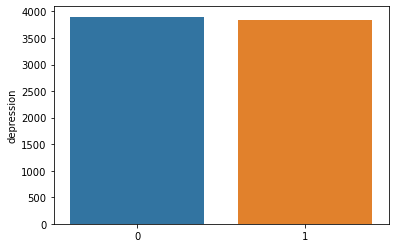

In [8]:
x=df['depression'].value_counts() 
print(x)
sns.barplot(x.index,x)  # data is balanced

In [9]:
# WORD-COUNT
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
print(df[df['depression']==0]['word_count'].mean()) #No Depression
print(df[df['depression']==1]['word_count'].mean()) #Depression

14.294615384615385
136.08718350300182


In [10]:
df.loc[5000]

text          tacce dang i ll get house off itunes i hear it...
depression                                                    0
word_count                                                   15
Name: 5000, dtype: object

### The average number of words in a depression text is 136 as compared to an average of 14.3 words in a non-depression text.

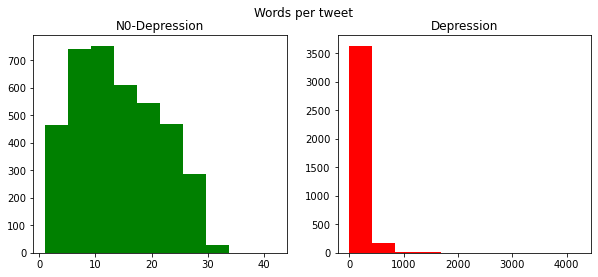

In [11]:
# PLOTTING WORD-COUNT
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,4))
words=df[df['depression']==0]['word_count']
ax1.hist(words,color='green')
ax1.set_title('N0-Depression')
words=df[df['depression']==1]['word_count']
ax2.hist(words,color='red')
ax2.set_title('Depression')
fig.suptitle('Words per tweet')
plt.show()

In [12]:
# CHARACTER-COUNT
df['char_count'] = df['text'].apply(lambda x: len(str(x)))
print(df[df['depression']==0]['char_count'].mean()) #No-Depression
print(df[df['depression']==1]['char_count'].mean()) #Depression


69.72
658.299138606108


#### Depression text is longer than non depression text.

# Text Pre-processing

In [13]:
#convert to lowercase, strip and remove punctuations
def preprocess(text):
    text = text.lower() 
    text=text.strip()  
    text=re.compile('<.*?>').sub('', text) 
    text = re.compile('[%s]' % re.escape(string.punctuation)).sub(' ', text)  
    text = re.sub('\s+', ' ', text)  
    text = re.sub(r'\[[0-9]*\]',' ',text) 
    text=re.sub(r'[^\w\s]', '', str(text).lower().strip())
    text = re.sub(r'\d',' ',text) 
    text = re.sub(r'\s+',' ',text) 
    return text


In [14]:
# STOPWORD REMOVAL
def stopword(string):
    a= [i for i in string.split() if i not in stopwords.words('english')]
    return ' '.join(a)


In [15]:
# LEMMATIZATION
# Initialize the lemmatizer
wl = WordNetLemmatizer()
 

In [16]:
# This is a helper function to map NTLK position tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN


In [17]:
import nltk
nltk.download('averaged_perceptron_tagger')
  

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\pritam\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [18]:
# Tokenize the sentence
def lemmatizer(string):
    word_pos_tags = nltk.pos_tag(word_tokenize(string)) # Get position tags
    a=[wl.lemmatize(tag[0], get_wordnet_pos(tag[1])) for idx, tag in enumerate(word_pos_tags)] # Map the position tag and lemmatize the word/token
    return " ".join(a)

In [19]:
def finalpreprocess(string):
    return lemmatizer(stopword(preprocess(string)))
df['clean_text'] = df['text'].apply(lambda x: finalpreprocess(x))
df.head()

,text,depression,word_count,char_count,clean_text
0,we understand that most people who reply immed...,1,813,4535,understand people reply immediately op invitat...
1,welcome to r depression s check in post a plac...,1,429,2394,welcome r depression check post place take mom...
2,anyone else instead of sleeping more when depr...,1,45,236,anyone else instead sleep depressed stay night...
3,i ve kind of stuffed around a lot in my life d...,1,110,510,kind stuffed around lot life delay inevitable ...
4,sleep is my greatest and most comforting escap...,1,54,281,sleep great comfort escape whenever wake day l...


# Word Embedding

In [21]:
#SPLITTING THE TRAINING DATASET INTO TRAIN AND TEST
X_train, X_test, y_train, y_test = train_test_split(df["clean_text"],df["depression"],test_size=0.2,shuffle=True)

#Tf-Idf
tfidf_vectorizer = TfidfVectorizer(use_idf=True)
X_train_vectors_tfidf = tfidf_vectorizer.fit_transform(X_train) 
X_test_vectors_tfidf = tfidf_vectorizer.transform(X_test)


In [22]:
X_train_vectors_tfidf

<6184x15048 sparse matrix of type '<class 'numpy.float64'>'
	with 164828 stored elements in Compressed Sparse Row format>

# ML Algorithm

In [23]:
#FITTING THE CLASSIFICATION MODEL using Logistic Regression(tf-idf)
lr_tfidf=LogisticRegression(solver = 'liblinear', C=10, penalty = 'l2')

lr_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset
y_predict = lr_tfidf.predict(X_test_vectors_tfidf)

y_prob = lr_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       801
           1       0.96      0.94      0.95       746

    accuracy                           0.95      1547
   macro avg       0.95      0.95      0.95      1547
weighted avg       0.95      0.95      0.95      1547

Confusion Matrix: [[770  31]
 [ 48 698]]
AUC: 0.9881147225485568


In [24]:
#FITTING THE CLASSIFICATION MODEL using Naive Bayes(tf-idf)

nb_tfidf = MultinomialNB()

nb_tfidf.fit(X_train_vectors_tfidf, y_train)  

#Predict y value for test dataset

y_predict = nb_tfidf.predict(X_test_vectors_tfidf)

y_prob = nb_tfidf.predict_proba(X_test_vectors_tfidf)[:,1]

print(classification_report(y_test,y_predict))

print('Confusion Matrix:',confusion_matrix(y_test, y_predict))
 
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)
print('AUC:', roc_auc)

              precision    recall  f1-score   support

           0       0.99      0.63      0.77       801
           1       0.71      0.99      0.83       746

    accuracy                           0.80      1547
   macro avg       0.85      0.81      0.80      1547
weighted avg       0.86      0.80      0.80      1547

Confusion Matrix: [[505 296]
 [  6 740]]
AUC: 0.9814223507478923


In [4]:
pip install wordcloud